By analyzing the patterns of total eclipses (i.e. non-partial) I aim to predict upcoming eclipses. The key idea here is to count the time (e.g. days) between consecutive eclipses and apply a ML-Algorithm on this pattern.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Functions for converting dates to a JD-format, and back (not important for the presenation; you can skip this):

In [2]:
def date_to_jd(date):
#transform date (either julian or gregorian) into a julian day number
    y = date[0]
    mo = date[1]
    d = date[2]
    h = date[3]
    mn = date[4]
    s = date[5]

    if date[:3] >= [1582,10,15]:
        #gregorian date
        return 367*y - (7*(y+int((mo+9)/12)))//4 - (3*(int((y+(mo-9)/7)/100)+1))//4+(275*mo)//9+d+1721028.5+h/24+mn/(24*60)+s/86400
    elif date[:3] <= [1582,10,4]:
        #julian date
        return 367*y - (7*(y+5001+int((mo-9)/7)))//4+(275*mo)//9+d+1729776.5+h/24+mn/(24*60)+s/86400

def jd_to_date(jd):
    Z = int(jd+0.5)
    F = (jd+0.5)%1
    if Z < 2299161:
        A = Z
    else:
        g = int((Z - 1867216.25) / 36524.25)
        A = Z + 1 + g - g//4 

    B = A + 1524
    C = int((B-122.1) / 365.25)
    D = int(365.25 * C)
    E = int((B-D) / 30.6001)
 
    d = B - D - int(30.6001*E) + F
    if E<14:
        mo = E-1
    else:
        mo = E-13    

    if mo >2:
        y = C- 4716
    else:
        y = C - 4715
    
    return str(y)+'-'+mak_2_dig(mo)+'-'+mak_2_dig(int(d))


Some helper functions for date-conversion (skip as well):

In [3]:
def mak_2_dig(x):
#transforms all integers bewteen 0 and 99 into a 2-digit string
    if x<10:
        return '0'+str(x)
    else:
        return str(x)


def transf_date(s):
    s = s.split()
    s[1] = str(dic_months[s[1]])
    return s[0]+':'+s[1]+':'+s[2]

dic_months = {'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June': 6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

Let's get started. First, we read the data, drop unnecessary columns, and convert the times of eclipses to a JD-format.

In [4]:
df = pd.read_csv("data/solar.csv")
df = df.loc[:, ['Calendar Date', 'Eclipse Time', 'Eclipse Type']]
#combine Date and Time to Time JD
df['Calendar Date'] = df['Calendar Date'].apply(lambda x:transf_date(x))
df['Time'] = df.loc[:,['Calendar Date', 'Eclipse Time']].apply(lambda x: x[0]+':'+x[1], axis = 1) 
df = df.drop(['Calendar Date', 'Eclipse Time'], axis=1)
df['Time JD']=df['Time'].apply(lambda x : date_to_jd([int(j) for j in x.split(':')]))
del df['Time']

From our modern worldview (we know about the earth moving around the sun, and the moon orbiting the earth), we know that the processes causing eclipses are periodic. Therefore, it might not be surprising to find visible patterns in the occurrence of eclipses. We here look at the time elapsing between consecutive eclipses:

In [5]:
df = df[df['Eclipse Type'].str[0] != 'P']     #exclude partial eclipses
##possibly exclude data prior to date
#date_start = date_to_jd([1400, 1, 1, 0, 0, 0])   #only use data after this date
#df = df[df['Time JD'] > date_start]
t_between = df['Time JD'].diff().tolist()   #count days between consecutive eclipses
t_between = t_between[1:-1]                 #drop first and last NaN

First we check the durations beween eclipses for regularities. 

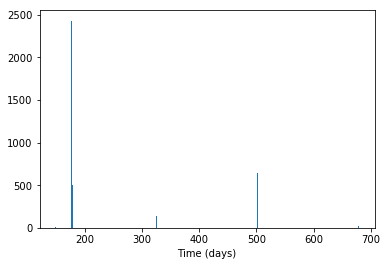

In [6]:
plt.hist(t_between,int(max(t_between))+1)
plt.xlabel('Time (days)')
plt.show()

This is even better than expected - there are only very few possibilities of times between eclipses! Essentially only 6 (we ignore uncertainties of +-2 days):

In [7]:
set([int(d) for d in t_between])

{147, 148, 175, 176, 177, 178, 179, 324, 325, 354, 501, 502, 678, 679, 680}

It might be worth noticing that the durations fulfill quite simple ratios: Based on l_0 = 147.5 days (the lowest of the times; almost never happening), we find that the ratios of the other durations and l_0 are roughly:

6/5, 11/5, 12/5, 17/5, 23/5

# Predictions

I will compare some ML-Classifiers to predict the next eclipses. First, we specify 'today', which separates the data into learning and testing data, then we split the dates and times between accordingly:

In [8]:
today = date_to_jd([2017, 3, 1, 0, 0,0])

df_before = df[df['Time JD'] <= today]
df_after = df[df['Time JD'] > today]
dates_before = df_before['Time JD'].tolist()
dates_after = df_after['Time JD'].tolist()
diff_before = [int(j) for j in t_between[:len(dates_before)-1]]  #recorded differences between past ecl.
diff_after =  [int(j) for j in t_between[len(dates_before)-1:]]   #differences betw. future ecl. to be predicted

The predictor should always predict the duration to the next eclipse from the past L eclipses. We specify this L (it is defined like this to make sure L is small enough that we can reasonably learn from the past), in fact I have optimized it through validation:

In [9]:
L = len(diff_before)//82

Then we create the training set from diff_before:

In [10]:
X = []
y = []
for j in range(len(diff_before)-L):
    X.append(diff_before[j:j+L])
    y.append(diff_before[j+L]) 

X = np.array(X)
y = np.array(y)

In order to perform some kind of validation, I split the training data again - namely, I take the last fraction of size p of the training set for this (it doesn't make sense to randomly pick the validation set, since adjacent entries of X are highly correlated):

In [11]:
p = 0.15 #fraction used for validation
X_val = X[int((1-p)*len(X)):]
y_val = y[int((1-p)*len(y)):]

X_train = X[:int((1-p)*len(X))]
y_train = y[:int((1-p)*len(y))]

We pick and train a learning algorithm on the (1-p)-training fraction:

In [17]:
#lrn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(500,), learning_rate = 'adaptive')
#lrn = SVC(kernel = 'linear', C=1000)     #just takes too long
lrn = RandomForestClassifier(1000)
lrn.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Now we test it on the validation set X_val (and accept deviations of +-1 days):

In [18]:
c = 0
s = lrn.predict(X_val)
for i in range(len(y_val)):
    if np.absolute(y_val[i] - s[i]) > 1:
        c += 1       #count wrong predictions
print("Predictions more than 1 day off: {}%".format(((c*1000)//len(y_val))/10))
print("Tested on {} samples".format(len(y_val)))

Predictions more than 1 day off: 5.6%
Tested on 916 samples


Among the three algorithms chosen above, the Random Forest Classifier produces the best results in a reasonable time, with an error rate greater than 5%.

But I want to compare this result with a prediction model using XGBoost (optimizing the parameters is not shown here).

In [16]:
lrn = xgb.XGBClassifier(learning_rate = 0.05, max_depth = 10, objective = "reg:linear")
lrn.fit(X_train, y_train)

c = 0
s = lrn.predict(X_val)
for i in range(len(y_val)):
    if np.absolute(y_val[i] - s[i]) > 1:
        c += 1       #count wrong predictions
print("Predictions more than 1 day off: {}%".format(((c*1000)//len(y_val))/10))
print("Tested on {} samples".format(len(y_val)))

Predictions more than 1 day off: 3.6%
Tested on 916 samples


This is great - XGBoost has an even lower error rate! We will stick to XGBoost for future predictions.

Having tested the quality of the prediction, we train the classifier again on the entire training set X, and then predict the next eclipses. Here, I will not only attempt to predict the next eclipse, but also some more eclipses ahead. Those further predictions will be based on the previous predictions, so errors are more likely to propagate.

In [19]:
N_future = 10   #number of predictions into the future
lrn.fit(X, y)   # optionally train the model again on the 'entire' past 
#prediction part: append every further prediction to the feature set

xx = np.array(X[-1])
xx = np.roll(xx,-1)
xx[-1] = y[-1]
y_pred = []
d_last = dates_before[-1]

for i in range(N_future):
    yy = lrn.predict([xx])
    y_pred.append(yy[0])
    xx = np.roll(xx,-1)
    xx[-1] = yy


print("Prediction:      ", y_pred)
print("Calculated/true: ", diff_after[:N_future])

Prediction:       [176, 679, 176, 177, 176, 177, 176, 501, 177, 176]
Calculated/true:  [176, 680, 176, 178, 176, 177, 176, 501, 177, 177]


The prediction is for the days between eclipses. In order to predict dates of eclipses, we compute the actual dates from this data:

In [20]:
days_pred = [d_last + i for i in np.cumsum(y_pred)]
print("Date (predicted)   Date (calculated/true)")
for i in range(len(days_pred)):
    print("  "+jd_to_date(days_pred[i])+"          "+jd_to_date(dates_after[i]))

Date (predicted)   Date (calculated/true)
  2017-08-21          2017-08-21
  2019-07-01          2019-07-02
  2019-12-24          2019-12-26
  2020-06-18          2020-06-21
  2020-12-11          2020-12-14
  2021-06-06          2021-06-10
  2021-11-29          2021-12-04
  2023-04-14          2023-04-20
  2023-10-08          2023-10-14
  2024-04-01          2024-04-08


This is pretty good - in the case where we are not too unlucky, the predictions should be accurate up to a couple of days. Of course, once a single prediction is off, all further predictions are rendered worthless. But we need to keep in mind that this is how we have designed our model - to just predict the next eclipse.